In [ ]:
!wget -c https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xf imagenette2-320.tgz

--2024-10-18 03:56:12--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.139.16, 54.231.199.200, 52.216.162.29, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.139.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  32.1MB/s    in 9.8s    

2024-10-18 03:56:23 (33.2 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]



In [ ]:
import torch
from transformers import ViTModel, ViTFeatureExtractor

# Load the pretrained ViT model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

Downloading: "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz" to ./data/imagenette2-320.tgz
100%|██████████| 326M/326M [00:08<00:00, 42.1MB/s]


Extracting file ./data/imagenette2-320.tgz to folder ./data/imagenette2-320
Extracting file 13418/13418 (100.0%)
482 1000


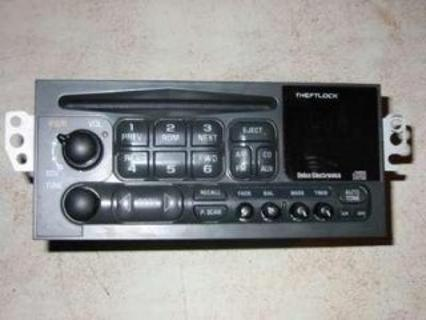

In [ ]:
import os
import sys
import re
import errno
import threading
import hashlib
import warnings
import tarfile
import zipfile
from urllib.parse import urlparse
from urllib.request import urlopen, Request
from pathlib import Path
from tqdm import tqdm

import torch
from typing import Any, Callable, Dict, List, Mapping, Optional, Type, TypeVar, Union
from torch.hub import download_url_to_file

default_cache_dir = os.path.join("./data")

from torchvision.datasets import ImageFolder, ImageNet
from torchvision.datasets.folder import default_loader

class ImageFolderIndex(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, index

class ImageNetIndex(ImageNet):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, index

class ImagenetteRemappedLabels(ImageFolderIndex):
    labelmap = {0: 0, 1: 217, 2: 482, 3: 491, 4: 497, 5: 566, 6: 569, 7: 571, 8: 574, 9: 701}

    def __init__(self, root, transform=None, target_transform=None, loader=default_loader, is_valid_file=None):
        super(ImagenetteRemappedLabels, self).__init__(root, transform=transform, target_transform=target_transform, loader=loader, is_valid_file=is_valid_file)

        # update labels to use new labels
        self.imgs = [(fname,self.labelmap[label]) for fname,label in self.imgs]
        self.samples = self.imgs

def download_if_needed(url, cache_dir=default_cache_dir, progress=True, check_hash=False,
                       delete_archive=True):
    parsed_url = urlparse(url)
    filename = os.path.basename(parsed_url.path)

    extensions = "".join(Path(filename).suffixes)
    basename = Path(filename).name.replace(extensions, "")

    extract_dir = os.path.join(cache_dir, basename)

    if os.path.exists(extract_dir):
        return extract_dir

    downloaded_file = download_file(url, cache_dir, progress, check_hash)

    print(f"Extracting file {downloaded_file} to folder {extract_dir}")
    extract_archive(downloaded_file, extract_dir, delete_archive=delete_archive, show_progress=progress)

    return extract_dir

def download_file(url, cache_dir=default_cache_dir, progress=True, check_hash=True):

    if url.startswith("http://") or url.startswith("https://"):
        cached_filename = download_from_url(url, data_dir=cache_dir, progress=progress, check_hash=check_hash)
    else:
        raise ValueError(f"URL should be a valid web url http/https://example.com/<filename>: {url}")

    return cached_filename

def download_from_url(url: str, data_dir: Optional[str] = None, progress: bool = True, check_hash: bool = False,
                      file_name: Optional[str] = None) -> Dict[str, Any]:
    if os.getenv('TORCH_MODEL_ZOO'):
        warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')

    if data_dir is None:
        hub_dir = torch.hub.get_dir()
        data_dir = default_cache_dir

    HASH_REGEX = re.compile(r'-([a-f0-9]{4,64})\.')

    try:
        os.makedirs(data_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise

    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if file_name is not None:
        filename = file_name
    cached_file = os.path.join(data_dir, filename)
    if not os.path.exists(cached_file):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
        hash_prefix = None
        if check_hash:
            matches = HASH_REGEX.findall(filename)
            hash_prefix = matches[-1] if matches else None

        download_url_to_file(url, cached_file, hash_prefix, progress=progress)

    return cached_file

def extract_archive(archive_path, extract_to, delete_archive=True, show_progress=True, progress_interval=0.005):
    if not os.path.exists(archive_path):
        raise FileNotFoundError(f"No archive file found at {archive_path}")

    def _report_progress(members, total):
        last_reported = 0
        interval_count = max(1, int(total * progress_interval))
        for i, member in enumerate(members):
            if show_progress and (i - last_reported >= interval_count or i == total - 1):
                print(f"Extracting file {i+1}/{total} ({(i+1)/total*100:.1f}%)", end='\r')
                last_reported = i
            yield member

    # Determine the archive type and extract
    if archive_path.endswith(('.tar', '.tar.gz', '.tgz', '.gz')):
        with tarfile.open(archive_path, 'r:*') as archive:
            members = archive.getmembers()
            archive.extractall(path=extract_to, members=_report_progress(members, len(members)))
    elif archive_path.endswith('.zip'):
        with zipfile.ZipFile(archive_path, 'r') as archive:
            members = archive.infolist()
            for i, member in enumerate(_report_progress(members, len(members))):
                archive.extract(member, path=extract_to)
    else:
        raise ValueError(f"Unsupported archive type for file {archive_path}")

    print()  # Print newline at end

    if delete_archive:
        os.remove(archive_path)

import os

def find_folder(data_dir, split):
    for root, dirs, files in os.walk(data_dir):
        if split in dirs:
            return os.path.join(root, split)
    return None  # Return None if not found

def imagenette2_s320_remap1k(split, cache_dir='./data', transform=None, **kwargs):
    url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz'
    data_dir = download_if_needed(url, cache_dir=cache_dir)
    root_dir = find_folder(data_dir, split)
    dataset = ImagenetteRemappedLabels(root_dir, transform=transform, **kwargs)

    if split=="val":
        assert len(dataset)==3925, f"Oops, expected 3925 images, got {len(dataset)}"
    elif split=="train":
        assert len(dataset)==9469, f"Oops, expected 9469 images, got {len(dataset)}"

    return dataset

dataset = imagenette2_s320_remap1k('val')
dataset

img,label,index = dataset[1000]
print(label, index)
img


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

image_batch = [img]
class Hook:
    def __init__(self, layer):
        self.layer = layer
        self.activations = None
        self.hook = layer.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.activations = output

    def close(self):
        self.hook.remove()

# Get a particular block, e.g., the 8th transformer block
for i in range(0,12):
  layer = model.encoder.layer[i]  # Example layer from ViT

# Register hook
  hook = Hook(layer)

  # Forward pass through the model
  inputs = feature_extractor(images=image_batch, return_tensors="pt")
  with torch.no_grad():
      outputs = model(**inputs)

  # Access hidden layer activations
  activations = hook.activations

  hook.close()
  torch.save(activations, f'vit_hidden_layer_activations{i}.pt')



/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:

# Forward pass through the model with output_attentions=True to get attention scores
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Get attention scores from the desired layer (e.g., layer 8)
attention_scores = outputs.attentions  # This is a list of attention scores for each layer
attention_scores

# Example: Visualize attention for layer 8, head 0
layer_idx = 8  # For example, the 9th layer (index 8)
head_idx = 0   # For example, the 1st attention head (index 0)

# Get the attention map for the selected layer and head
attention_map = attention_scores[layer_idx][0, head_idx, :, :].cpu().detach().numpy()

# Plot the attention map
import matplotlib.pyplot as plt
plt.imshow(attention_map, cmap='viridis')
plt.colorbar()
plt.title(f'Attention Map - Layer {layer_idx}, Head {head_idx}')
plt.show()


(None, None, None, None, None, None, None, None, None, None, None, None)

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

cam = GradCAM(model=model, target_layers=[model.encoder.layer[8]])  # Example: using the 8th block

grayscale_cam = cam(input_tensor=inputs['pixel_values'], target_category=None)  # Can specify target category

cam_image = show_cam_on_image(np.array(image)/255., grayscale_cam[0], use_rgb=True)

# Visualize the result
plt.imshow(cam_image)
plt.title(f'Grad-CAM - Layer 8')
plt.show()

In [ ]:
import torch

# Hook class to capture gradients
class GradCAMHook:
    def __init__(self, layer):
        self.gradients = None
        self.activations = None
        self.hook = layer.register_forward_hook(self.forward_hook)
        self.hook_grad = layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def close(self):
        self.hook.remove()
        self.hook_grad.remove()

layer = model.encoder.layer[11]

hook = GradCAMHook(layer)

inputs = feature_extractor(images=image_batch, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits

target_class = logits.argmax(dim=-1)
loss = logits[:, target_class]
loss.backward()

gradients = hook.gradients
activations = hook.activations

hook.close()

weights = gradients.mean(dim=1)

cam = (weights[:, None] * activations).sum(dim=2).squeeze(0)  # Shape: [197]

cam = cam[1:]  # Shape: [196]

# Normalize the CAM for visualization
cam = (cam - cam.min()) / (cam.max() - cam.min())

import numpy as np
import matplotlib.pyplot as plt

patch_size = int(np.sqrt(cam.shape[0]))
cam_grid = cam.reshape(patch_size, patch_size).cpu().detach().numpy()

# Visualize the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(cam_grid, cmap='jet', interpolation='nearest')
plt.colorbar(label='Importance Score')
plt.title('Transformer-CAM Heatmap')
plt.show()


AttributeError: 'BaseModelOutputWithPooling' object has no attribute 'logits'